# DeepLab

In [1]:
'''
IMPORTS
'''
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, BatchNormalization, Dropout, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.image import resize, ResizeMethod
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image

import random
import os
import numpy as np
from numpy import load
import matplotlib.pyplot as plt

'''
DATA PATHS
'''
TOP_DIR = '/tf/Notebooks/Iwashita'

TRAIN_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment1/Train'
VAL_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment1/Validate'
TEST_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment1/Test'

'''
OUTPUTS PATH
'''
WEIGHTS_PATH = TOP_DIR + '/Output/Weights/'
METRICS_PATH = TOP_DIR + '/Output/Metrics/'

'''
GPU
'''
gpu_p40 = '/device:GPU:0'

get_ipython().system('nvidia-smi')
print(tf.config.list_physical_devices('GPU'))

'''
TRAINING DATA
'''
exp1_rgb_X_train = load(TRAIN_DIR + '/exp1_rgb_X_train_dl.npy')
exp1_ir_X_train = load(TRAIN_DIR + '/exp1_ir_X_train_dl.npy')
exp1_y_train = load(TRAIN_DIR + '/exp1_y_train_dl.npy')

'''
VALIDATION DATA
'''
exp1_rgb_X_val = load(VAL_DIR + '/exp1_rgb_X_val_dl.npy')
exp1_ir_X_val = load(VAL_DIR + '/exp1_ir_X_val_dl.npy')
exp1_y_val = load(VAL_DIR + '/exp1_y_val_dl.npy')

'''
TEST DATA
'''
exp1_rgb_X_test = load(TEST_DIR + '/exp1_rgb_X_test_dl.npy')
exp1_ir_X_test = load(TEST_DIR + '/exp1_ir_X_test_dl.npy')
exp1_y_test = load(TEST_DIR + '/exp1_y_test_dl.npy')

'''
INTERSECTION OVER UNION
'''
def iou(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]
    area_pred = np.histogram(y_pred, bins=num_classes)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    union[union == 0] = 1e-9
    iou = intersection / union

    return iou, np.mean(np.diag(iou))

'''
PIXEL ACCURACY
'''
def pixel_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.size

'''
MEAN ACCURACY
'''
def mean_accuracy(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]

    area_true[area_true == 0] = 1e-9
    accuracy = np.diag(intersection) / area_true

    return np.mean(accuracy)

'''
FREQUENCY-WEIGHTED INTERSECTION OVER UNION
'''
def fw_iou(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]
    area_pred = np.histogram(y_pred, bins=num_classes)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    union[union == 0] = 1e-9
    iou = intersection / union
    fw_iou = np.sum(area_true * iou) / np.sum(area_true)

    return fw_iou

def display_one_hot_annotation(annotations_onehot):
    label = np.argmax(annotations_onehot, axis=-1)
    cmap = plt.get_cmap('tab10', 7)

    plt.imshow(label, cmap=cmap)
    plt.colorbar(ticks=range(7), format=plt.FuncFormatter(lambda val, loc: {
        0: "unlabeled",
        1: "sand",
        2: "soil",
        3: "ballast",
        4: "rock",
        5: "bedrock",
        6: "rocky terrain"
    }[val]))
    plt.show()

print("Done")

2023-10-15 19:15:55.275422: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sun Oct 15 19:15:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:05:00.0 Off |                  Off |
| N/A   34C    P8     9W / 250W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

2023-10-15 19:15:57.437766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 19:15:57.447532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 19:15:57.447903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
'''
CONVERT IR TO 3-CH
'''
def convert_ir_3ch(ir_images):

    ir_3ch_images = []
    
    for i in range(len(ir_images)):
        ir = np.dstack([ir_images[i]] * 3)

        ir_3ch_images.append(ir)
    
    return np.array(ir_3ch_images)

exp1_ir_X_train = convert_ir_3ch(exp1_ir_X_train)
exp1_ir_X_val = convert_ir_3ch(exp1_ir_X_val)
exp1_ir_X_test = convert_ir_3ch(exp1_ir_X_test)

print("Done")

Done


In [4]:
'''
MODEL PARAMS
'''
INPUT_DIMS = (572, 572, 3)

BATCH_SIZE = 2
EPOCHS = 1000 

LEARNING_RATE = 1e-4
PATIENCE = 15
FACTOR = 0.1

DROPOUT_RATE = 0.5

TRAINABLE_LAYERS = 300

LOSS_ = BinaryCrossentropy()
METRICS_ = [BinaryAccuracy()]

EXP1_FILENAME = "tdeeplab_tl_exp1_batch{}_epoch{}_lr{}_p{}_f{}".format(
    BATCH_SIZE, EPOCHS, LEARNING_RATE, PATIENCE, FACTOR)

print("Done")

Done


2023-10-15 19:15:58.008431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 19:15:58.008722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 19:15:58.008955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### DeepLab Common

In [5]:
'''
Atrous Spatial Pyramid Pooling
'''
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLab(shape):
    """ Inputs """
    inputs = Input(shape)
    
    """ Pre-trained ResNet101 """
    base_model = ResNet101(weights='imagenet', include_top=False, input_tensor=inputs)
    
    for layer in base_model.layers[:TRAINABLE_LAYERS]:
        layer.trainable = False
    for layer in base_model.layers[TRAINABLE_LAYERS:]:
        layer.trainable = True

    """ Pre-trained ResNet101 Output """
    image_features = base_model.get_layer('conv4_block23_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    """ Spatial Pyramid Pooling (SPP) """
    # Apply different pooling sizes
    pool1 = GlobalAveragePooling2D()(x_a)
    pool2 = GlobalAveragePooling2D()(x_a)
    pool3 = GlobalAveragePooling2D()(x_a)

    # Concatenate pooled features
    spp_features = Concatenate()([pool1, pool2, pool3])

    # Reshape to match x_b's shape
    spp_features = tf.keras.layers.Reshape((1, 1, -1))(spp_features)
    spp_features = UpSampling2D((x_b.shape[1], x_b.shape[2]), interpolation="bilinear")(spp_features)

    x = Concatenate()([spp_features, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(DROPOUT_RATE)(x) 

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(DROPOUT_RATE)(x) 
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(7, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

def DeepLab_TL():
    '''
    INPUTS
    '''
    inputs_rgb = Input(INPUT_DIMS)
    inputs_ir = Input(INPUT_DIMS)
    
    '''
    BRANCHES
    '''
    model_rgb = DeepLab(INPUT_DIMS)
    model_ir = DeepLab(INPUT_DIMS)
    
    '''
    OUTPUT
    '''
    output_rgb = model_rgb(inputs_rgb)
    output_ir = model_ir(inputs_ir)
    
    output_sum = Add()([output_rgb, output_ir])
    
    '''
    MODEL
    '''
    model = Model(inputs=[inputs_rgb, inputs_ir], outputs = output_sum)
    
    '''
    RETURN
    '''
    return model

'''
TRAIN
'''
def DeepLab_Train(
    model, 
    X_rgb_train, X_ir_train, y_train, 
    X_rgb_val, X_ir_val, y_val, 
    weights_filename):
    
    try:
        with tf.device(gpu_p40):
            model.compile(
                optimizer=Adam(learning_rate=LEARNING_RATE), 
                loss=LOSS_, 
                metrics=METRICS_)
            
            callbacks = [
                ModelCheckpoint(weights_filename, save_best_only=True, save_weights_only=True, verbose=1),
                EarlyStopping(patience=PATIENCE, verbose=1),
                ReduceLROnPlateau(factor=FACTOR, patience=PATIENCE, min_lr=LEARNING_RATE, verbose=1)]
            
            history = model.fit(
                [X_rgb_train, X_ir_train], y_train,
                validation_data=([X_rgb_val, X_ir_val], y_val),
                batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, verbose=2)
            
    except RuntimeError as e:
        print(e)

'''
SCORE
'''
def DeepLab_Score(model, weights_filename, metrics_filename, X_rgb_test, X_ir_test, y_test):
    
    try:
        with tf.device(gpu_p40):
            score = model.evaluate([X_rgb_test, X_ir_test], y_test, batch_size=2, verbose=1)

    except RuntimeError as e:
        print(e)

    # Print and save the test metrics
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

    with open(metrics_filename, "a") as f:
        f.write(f"\Test Loss: {score[0]}\n")
        f.write(f"\Test Accuracy: {score[1]}\n")
        
'''
PREDICT
'''
def DeepLab_Predict(model, X_rgb_test, X_ir_test):
    try:
        with tf.device(gpu_p40):
            pred = model.predict([X_rgb_test, X_ir_test], batch_size=BATCH_SIZE)
            
    except RuntimeError as e:
        print(e)
        
    return pred

'''
DISPLAY RANDOM RESULT
'''
def DeepLab_Display(X_rgb_test, X_ir_test, y_test, y_pred):

    try:
        with tf.device(gpu_p40):
            fig, axes = plt.subplots(1, 4, figsize=(10, 6))
            n = random.randint(0, len(X_rgb_test)-1)
            cmap = plt.get_cmap('tab10', 7)
    
            axes[0].imshow(X_rgb_test[n])
            axes[1].imshow(X_ir_test[n])
            axes[2].imshow(np.argmax(y_test[n], axis=-1), cmap=cmap)
            axes[3].imshow(np.argmax(y_pred[n], axis=-1), cmap=cmap)
                                           
            axes[0].set_title("RGB")
            axes[1].set_title("IR")
            axes[2].set_title("Annotation")
            axes[3].set_title("Predicted")
    
            for ax in axes.flatten():
                ax.axis("off")
        
            plt.tight_layout()
            plt.show()
            
    except RuntimeError as e:
        print(e)
'''
METRICS
'''
def DeepLab_Metrics(y_test, y_pred, metrics_filename):

    try:
        with tf.device(gpu_p40):
            y_pred_classes = np.argmax(y_pred, axis=-1)
            y_true_classes = np.argmax(y_test, axis=-1)
    
            num_classes=7

            iou_values, mean_iou = iou(y_true_classes, y_pred_classes, num_classes)
            pixel_acc = pixel_accuracy(y_true_classes, y_pred_classes)
            mean_acc = mean_accuracy(y_true_classes, y_pred_classes, num_classes)
            fw_iou_value = fw_iou(y_true_classes, y_pred_classes, num_classes)

            print(f"Mean IoU: {mean_iou}")
            print(f"Pixel accuracy: {pixel_acc}")
            print(f"Mean accuracy: {mean_acc}")
            print(f"Frequency-Weighted IoU: {fw_iou_value}")
    
            with open(metrics_filename, "a") as f:
                f.write("\nIoU Values:\n")
                for i, iou_val in enumerate(iou_values):
                    f.write(f"Class {i}: {iou_val}\n")
                f.write(f"\nMean IoU: {mean_iou}\n")
                f.write(f"Pixel Accuracy: {pixel_acc}\n")
                f.write(f"Mean Accuracy: {mean_acc}\n")
                f.write(f"Frequency Weighted IoU: {fw_iou_value}\n")
    except RuntimeError as e:
        print(e)

print("Done")

Done


In [6]:
'''
FILENAMES
'''
exp1_weights_filename = os.path.join(WEIGHTS_PATH, 'tdeeplab_tl_exp1.h5')
exp1_metrics_filename = os.path.join(METRICS_PATH, 'tdeeplab_tl_exp1.txt')

print("Done")

Done


In [7]:
'''
model
'''
try:
    with tf.device(gpu_p40):
        exp1_model = DeepLab_TL()         
except RuntimeError as e:
    print(e)

print("Done")

Done


In [8]:
'''
TRAIN
'''
DeepLab_Train(
    exp1_model, 
    exp1_rgb_X_train, exp1_ir_X_train, exp1_y_train, 
    exp1_rgb_X_val, exp1_ir_X_val, exp1_y_val, 
    exp1_weights_filename)

print("Done")

Epoch 1/1000


2023-10-15 19:16:14.415702: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-15 19:16:16.586298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-15 19:16:18.653299: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f5cc6dd03f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-15 19:16:18.653336: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
2023-10-15 19:16:18.657719: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-15 19:16:18.819365: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluste


Epoch 1: val_loss improved from inf to 0.65507, saving model to /tf/Notebooks/Iwashita/Output/Weights/tdeeplab_tl_exp1.h5
28/28 - 40s - loss: 0.5805 - binary_accuracy: 0.8029 - val_loss: 0.6551 - val_binary_accuracy: 0.6369 - lr: 1.0000e-04 - 40s/epoch - 1s/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.65507 to 0.59867, saving model to /tf/Notebooks/Iwashita/Output/Weights/tdeeplab_tl_exp1.h5
28/28 - 14s - loss: 0.5199 - binary_accuracy: 0.8142 - val_loss: 0.5987 - val_binary_accuracy: 0.7165 - lr: 1.0000e-04 - 14s/epoch - 502ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.59867 to 0.54909, saving model to /tf/Notebooks/Iwashita/Output/Weights/tdeeplab_tl_exp1.h5
28/28 - 14s - loss: 0.4800 - binary_accuracy: 0.8323 - val_loss: 0.5491 - val_binary_accuracy: 0.7533 - lr: 1.0000e-04 - 14s/epoch - 516ms/step
Epoch 4/1000

Epoch 4: val_loss did not improve from 0.54909
28/28 - 12s - loss: 0.4757 - binary_accuracy: 0.8301 - val_loss: 0.5859 - val_binary_accuracy: 0.7308 - lr:

In [9]:
'''
SCORE
'''
DeepLab_Score(
    exp1_model, 
    exp1_weights_filename, exp1_metrics_filename, 
    exp1_rgb_X_test, exp1_ir_X_test, exp1_y_test)

print("Done")

14/14 [==============================] - 2s 152ms/step - loss: 0.8255 - binary_accuracy: 0.8525
Test loss: 0.8255391120910645
Test accuracy: 0.8524695038795471
Done


In [10]:
'''
PREDICT
'''
exp1_y_pred = DeepLab_Predict(exp1_model, exp1_rgb_X_test, exp1_ir_X_test)

print("Done")

14/14 [==============================] - 5s 149ms/step
Done


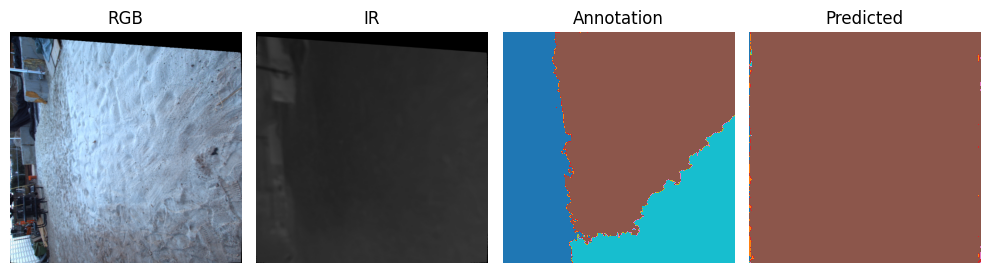

In [11]:
'''
DISPLAY RANDOM RESULT
'''
DeepLab_Display(exp1_rgb_X_test, exp1_ir_X_test, exp1_y_test, exp1_y_pred)

In [12]:
'''
METRICS
'''
DeepLab_Metrics(exp1_y_test, exp1_y_pred, exp1_metrics_filename)

Mean IoU: 0.1904099830268821
Pixel accuracy: 0.5356719329621428
Mean accuracy: 0.28294792449354667
Frequency-Weighted IoU: 0.5469245248271267
